# Model Training

---



There are 3 base modules:


1.   Text Feature
2.   Image Semantics
3.   Visual Tempering


The similarity module is built on top of the text and image modules. The final multimodal fusion layer is built all other modules.



In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
from google.colab import drive
import pandas as pd

drive.mount('/drive')
final_df = pd.read_csv('/drive/My Drive/BT4222/final_df_14_04_2025_1631.csv')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).




```
# This is formatted as code
```

### v1 with only raw features

In [ ]:
# v1, with just raw features
class MCNN_Precomputed(nn.Module):
    def __init__(self):
        super(MCNN_Precomputed, self).__init__()

        # Initial projections
        self.text_proj = nn.Linear(768, 512)
        self.image_proj = nn.Linear(2048, 512)
        self.ela_proj = nn.Linear(4, 128)
        self.similarity_proj = nn.Linear(1, 64)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 512 + 128 + 64, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, bert_emb, cnn_emb, ela_features):
        # Projections
        text_feat = self.text_proj(bert_emb)       # (B, 512)
        img_feat = self.image_proj(cnn_emb)        # (B, 512)
        ela_out = self.ela_proj(ela_features)      # (B, 128)

        # Cosine similarity
        sim = F.cosine_similarity(text_feat, img_feat, dim=1).unsqueeze(1)
        sim_out = self.similarity_proj(sim)

        # Fusion
        combined = torch.cat([text_feat, img_feat, ela_out, sim_out], dim=1)
        logits = self.classifier(combined)
        return logits

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for bert, cnn, read, ela, labels in tqdm(train_loader):
            bert, cnn, read, ela, labels = bert.to(device), cnn.to(device), read.to(device), ela.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(bert, cnn, ela)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        print(f"Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_mcnn_model.pth")

def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for bert, cnn, read, ela, labels in dataloader:
            bert, cnn, read, ela, labels = bert.to(device), cnn.to(device), read.to(device), ela.to(device), labels.to(device)
            outputs = model(bert, cnn, ela)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

### v2 with attention mechanism

In [ ]:
# v2
class MCNN_Precomputed(nn.Module):
    def __init__(self):
        super(MCNN_Precomputed, self).__init__()

        # Initial projections with activations and normalization
        self.text_proj = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        self.image_proj = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        self.ela_proj = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )

        self.similarity_proj = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.LayerNorm(64)
        )

        # Cross-modal attention
        self.text_to_image_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_to_text_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Feedforward after attention
        self.text_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.image_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 512 + 128 + 64, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, bert_emb, cnn_emb, ela_features):
        # Project features
        text_feat = self.text_proj(bert_emb)      # (B, 512)
        img_feat = self.image_proj(cnn_emb)       # (B, 512)
        ela_out = self.ela_proj(ela_features)     # (B, 128)

        # Prepare for attention
        text_seq = text_feat.unsqueeze(1)         # (B, 1, 512)
        img_seq = img_feat.unsqueeze(1)           # (B, 1, 512)

        # Cross-modal attention
        text_attn, _ = self.text_to_image_attn(query=text_seq, key=img_seq, value=img_seq)
        img_attn, _ = self.image_to_text_attn(query=img_seq, key=text_seq, value=text_seq)

        # Residual + FFN + Norm
        text_attn = self.text_norm(text_attn + self.text_ffn(text_attn))  # (B, 1, 512)
        img_attn = self.image_norm(img_attn + self.image_ffn(img_attn))   # (B, 1, 512)

        # Remove sequence dimension
        text_attn = text_attn.squeeze(1)  # (B, 512)
        img_attn = img_attn.squeeze(1)    # (B, 512)

        # Cosine similarity
        sim = F.cosine_similarity(text_attn, img_attn, dim=1).unsqueeze(1)  # (B, 1)
        sim_out = self.similarity_proj(sim)  # (B, 64)

        # Concatenate and classify
        combined = torch.cat([text_attn, img_attn, ela_out, sim_out], dim=1)  # (B, 1216)
        logits = self.classifier(combined)
        return logits


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for bert, cnn, read, ela, labels in tqdm(train_loader):
            bert, cnn, read, ela, labels = bert.to(device), cnn.to(device), read.to(device), ela.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(bert, cnn, ela)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        print(f"Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_mcnn_model.pth")

def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for bert, cnn, read, ela, labels in dataloader:
            bert, cnn, read, ela, labels = bert.to(device), cnn.to(device), read.to(device), ela.to(device), labels.to(device)
            outputs = model(bert, cnn, ela)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total


### v3 version attention and readability

In [54]:
# v3
class MCNN_Precomputed(nn.Module):
    def __init__(self):
        super(MCNN_Precomputed, self).__init__()

        self.text_proj = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        self.image_proj = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        self.readability_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.ela_proj = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )

        self.sentiment_proj = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.LayerNorm(64)
        )

        self.similarity_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.text_attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Cross-modal attention
        self.text_to_image_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_to_text_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Feedforward after attention
        self.text_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.image_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 512 + 128 + 16 + 16 + 64, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, bert_emb, cnn_emb, readability_features, ela_features, sentiment_features):
        # Projections
        text_feat = self.text_proj(bert_emb)       # (B, 512)
        img_feat = self.image_proj(cnn_emb)        # (B, 512)
        readability_features = readability_features.view(-1, 1)
        read_out = self.readability_proj(readability_features)  # (B, 64)
        ela_out = self.ela_proj(ela_features)      # (B, 128)
        sentiment_out = self.sentiment_proj(sentiment_features)

        # Add sequence dimension for attention
        text_seq = text_feat.unsqueeze(1)  # (B, 1, 512)
        img_seq = img_feat.unsqueeze(1)    # (B, 1, 512)

        text_attn_out, _ = self.text_attention(text_seq, text_seq, text_seq)
        text_attn = self.text_norm(text_attn_out + self.text_ffn(text_attn_out))  # (B, 1, 512)
        img_attn_out, _ = self.image_attention(img_seq, img_seq, img_seq)
        img_attn = self.image_norm(img_attn_out + self.image_ffn(img_attn_out))  # (B, 1, 512)

        # Remove sequence dim
        text_attn_out = text_attn_out.squeeze(1)
        img_attn_out = img_attn_out.squeeze(1)

        # Cosine similarity
        sim = F.cosine_similarity(text_attn_out, img_attn_out, dim=1).unsqueeze(1)
        sim_out = self.similarity_proj(sim)

        # Fusion
        combined = torch.cat([text_attn_out, img_attn_out, read_out, ela_out, sentiment_out, sim_out], dim=1)
        logits = self.classifier(combined)
        return logits

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for bert, cnn, read, ela, sentiment, labels in tqdm(train_loader):
            bert, cnn, read, ela, sentiment, labels = bert.to(device), cnn.to(device), read.to(device), ela.to(device), sentiment.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(bert, cnn, read, ela, sentiment)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        print(f"Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_mcnn_model.pth")

def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for bert, cnn, read, ela, sentiment, labels in dataloader:
            bert, cnn, read, ela, sentiment, labels = bert.to(device), cnn.to(device), read.to(device), ela.to(device), sentiment.to(device), labels.to(device)
            outputs = model(bert, cnn, read, ela, sentiment)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

### v4 version attention and readability

In [52]:
class MCNN_Precomputed(nn.Module):
    def __init__(self):
        super(MCNN_Precomputed, self).__init__()

        self.text_proj = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        # Main image pathway
        self.image_proj = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        # ELA features pathway
        self.ela_proj = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )

        # Early fusion between image and ELA features
        self.early_fusion = nn.Sequential(
            nn.Linear(512 + 128, 512),  # Combining image features with ELA features
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.LayerNorm(512)
        )

        self.readability_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.sentiment_proj = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.LayerNorm(64)
        )

        self.similarity_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        # Self-attention for text and image
        self.text_attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Cross-modal attention
        self.text_to_image_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_to_text_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Feedforward after attention
        self.text_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.image_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 512 + 16 + 64 + 16, 512),  # Adjusted dimensions
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, bert_emb, cnn_emb, readability_features, ela_features, sentiment_features):
        # Text processing
        text_feat = self.text_proj(bert_emb)  # (B, 512)

        # Image processing
        img_feat = self.image_proj(cnn_emb)  # (B, 512)

        # ELA features processing
        ela_out = self.ela_proj(ela_features)  # (B, 128)

        # Properly apply early fusion between image features and ELA features
        # This is the key improvement - combining image and ELA features early in the network
        concat_img_ela = torch.cat([img_feat, ela_out], dim=1)  # (B, 512+128)
        fused_img_feat = self.early_fusion(concat_img_ela)  # (B, 512)

        # Process readability features
        readability_features = readability_features.view(-1, 1)
        read_out = self.readability_proj(readability_features)  # (B, 16)

        # Process sentiment features
        sentiment_out = self.sentiment_proj(sentiment_features)  # (B, 64)

        # Add sequence dimension for attention
        text_seq = text_feat.unsqueeze(1)  # (B, 1, 512)
        # Use the fused image features for attention
        img_seq = fused_img_feat.unsqueeze(1)  # (B, 1, 512)

        # Self-attention on text
        text_attn_out, _ = self.text_attention(text_seq, text_seq, text_seq)
        text_attn = self.text_norm(text_attn_out + self.text_ffn(text_attn_out))  # (B, 1, 512)

        # Self-attention on fused image
        img_attn_out, _ = self.image_attention(img_seq, img_seq, img_seq)
        img_attn = self.image_norm(img_attn_out + self.image_ffn(img_attn_out))  # (B, 1, 512)

        # Cross-modal attention
        text_to_img, _ = self.text_to_image_attn(query=text_attn, key=img_attn, value=img_attn)
        img_to_text, _ = self.image_to_text_attn(query=img_attn, key=text_attn, value=text_attn)

        # Remove sequence dimension
        text_final = text_to_img.squeeze(1)  # (B, 512)
        img_final = img_to_text.squeeze(1)  # (B, 512)

        # Calculate similarity between modalities
        sim = F.cosine_similarity(text_final, img_final, dim=1).unsqueeze(1)  # (B, 1)
        sim_out = self.similarity_proj(sim)  # (B, 16)

        # Final feature fusion for classification
        combined = torch.cat([text_final, img_final, read_out, sentiment_out, sim_out], dim=1)
        logits = self.classifier(combined)

        return logits

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_acc = 0.0
    plateau_count = 0
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for bert, cnn, read, ela, sentiment, labels in tqdm(train_loader):
            bert = bert.to(device)
            cnn = cnn.to(device)
            read = read.to(device)
            ela = ela.to(device)
            sentiment = sentiment.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(bert, cnn, read, ela, sentiment)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate(model, val_loader, device)
        print(f"Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Update learning rate based on validation accuracy
        lr_scheduler.step(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_mcnn_model.pth")
            plateau_count = 0
        else:
            plateau_count += 1

        # Early stopping to prevent overfitting
        if plateau_count >= 10:
            print("Early stopping triggered")
            break

def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for bert, cnn, read, ela, sentiment, labels in dataloader:
            bert = bert.to(device)
            cnn = cnn.to(device)
            read = read.to(device)
            ela = ela.to(device)
            sentiment = sentiment.to(device)
            labels = labels.to(device)

            outputs = model(bert, cnn, read, ela, sentiment)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

In [112]:
# @title v5 (additional features)
class MCNN_Precomputed(nn.Module):
    def __init__(self):
        super(MCNN_Precomputed, self).__init__()

        # Projections for existing features (text, image, readability, etc.)
        self.text_proj = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        self.image_proj = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        self.readability_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.ela_proj = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )

        self.sentiment_proj = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.LayerNorm(64)
        )

        self.similarity_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        # Projections for additional features
        self.avg_word_count_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.avg_word_length_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.publish_day_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.publish_month_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.publish_year_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.score_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        # Attention layers
        self.text_attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Cross-modal attention
        self.text_to_image_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_to_text_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Feedforward after attention
        self.text_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.image_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 512 + 128 + 64 + 16 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, bert_emb, cnn_emb, readability_features, ela_features, sentiment_features, avg_word_count, avg_word_length, publish_day, publish_month, publish_year, score):
        # Projections for existing features
        text_feat = self.text_proj(bert_emb)
        img_feat = self.image_proj(cnn_emb)
        readability_feat = self.readability_proj(readability_features.view(-1, 1))
        ela_feat = self.ela_proj(ela_features)
        sentiment_feat = self.sentiment_proj(sentiment_features)
        sim_feat = self.similarity_proj(F.cosine_similarity(text_feat, img_feat, dim=1).unsqueeze(1))

        # Projections for additional features
        avg_word_count_feat = self.avg_word_count_proj(avg_word_count.view(-1, 1))
        avg_word_length_feat = self.avg_word_length_proj(avg_word_length.view(-1, 1))
        publish_day_feat = self.publish_day_proj(publish_day.view(-1, 1))
        publish_month_feat = self.publish_month_proj(publish_month.view(-1, 1))
        publish_year_feat = self.publish_year_proj(publish_year.view(-1, 1))
        score_feat = self.score_proj(score.view(-1, 1))

        # Add sequence dimension for attention
        text_seq = text_feat.unsqueeze(1)
        img_seq = img_feat.unsqueeze(1)

        text_attn_out, _ = self.text_attention(text_seq, text_seq, text_seq)
        text_attn = self.text_norm(text_attn_out + self.text_ffn(text_attn_out))
        img_attn_out, _ = self.image_attention(img_seq, img_seq, img_seq)
        img_attn = self.image_norm(img_attn_out + self.image_ffn(img_attn_out))

        # Remove sequence dimension
        text_attn_out = text_attn_out.squeeze(1)
        img_attn_out = img_attn_out.squeeze(1)

        # Fusion
        combined = torch.cat([
            text_attn_out, img_attn_out, readability_feat, ela_feat, sentiment_feat, sim_feat,
            avg_word_count_feat, avg_word_length_feat, publish_day_feat, publish_month_feat, publish_year_feat, score_feat
        ], dim=1)

        logits = self.classifier(combined)
        return logits


def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, publish_day, publish_month, publish_year, score, labels in tqdm(train_loader):
            # Move the data to the correct device (e.g., 'cuda' or 'cpu')
            bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, publish_day, publish_month, publish_year, score, labels = (
                bert.to(device), cnn.to(device), read.to(device), ela.to(device), sentiment.to(device),
                avg_word_count.to(device), avg_word_length.to(device), publish_day.to(device),
                publish_month.to(device), publish_year.to(device), score.to(device), labels.to(device)
            )

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, publish_day, publish_month, publish_year, score)

            # Calculate the loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track the running loss and accuracy
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # Calculate training accuracy
        train_acc = correct / total

        # Validate the model
        val_acc = evaluate(model, val_loader, device)

        # Print training and validation stats
        print(f"Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_mcnn_model.pth")
            plateau_count = 0
        else:
            plateau_count += 1

        # Early stopping to prevent overfitting
        if plateau_count >= 5:
            print("Early stopping triggered")
            break
def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, publish_day, publish_month, publish_year, score, labels in dataloader:
            # Move the data to the correct device (e.g., 'cuda' or 'cpu')
            bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, publish_day, publish_month, publish_year, score, labels = (
                bert.to(device), cnn.to(device), read.to(device), ela.to(device), sentiment.to(device),
                avg_word_count.to(device), avg_word_length.to(device), publish_day.to(device),
                publish_month.to(device), publish_year.to(device), score.to(device), labels.to(device)
            )

            # Forward pass
            outputs = model(bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, publish_day, publish_month, publish_year, score)

            # Get predictions and compute accuracy
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Return accuracy
    return correct / total


### creating train val test

In [21]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14595 entries, 0 to 14594
Data columns (total 48 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             14595 non-null  int64  
 1   domain                 14595 non-null  object 
 2   title                  8383 non-null   object 
 3   text                   14547 non-null  object 
 4   publish_date           3395 non-null   object 
 5   image_path             14595 non-null  object 
 6   score                  14595 non-null  int64  
 7   label                  14595 non-null  int64  
 8   translated_text        14547 non-null  object 
 9   translation_status     6202 non-null   object 
 10  translation_timestamp  13624 non-null  object 
 11  text_length            14595 non-null  int64  
 12  text_char_count        14595 non-null  int64  
 13  avg_word_length        14595 non-null  float64
 14  readability_score      14595 non-null  float64
 15  la

In [61]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import ast

# Initial train/test split
train_df, temp_df = train_test_split(final_df, test_size=0.2, stratify=final_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

class MCNNDataset(Dataset):
    def __init__(self, dataframe):
        # Text and image embeddings
        self.bert = torch.tensor(dataframe['bert_embeddings'].apply(ast.literal_eval).tolist(), dtype=torch.float32)
        self.cnn = torch.tensor(dataframe['cnn_embeddings'].apply(ast.literal_eval).tolist(), dtype=torch.float32)

        # Readability score
        self.read = torch.tensor(dataframe['readability_score'].values, dtype=torch.float32)

        # ELA features
        self.ela = torch.tensor(dataframe[['ela_mean', 'ela_std', 'ela_max', 'ela_entropy']].values, dtype=torch.float32)

        # Sentiment features
        self.sentiment = torch.tensor(dataframe[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']].values, dtype=torch.float32)

        # Additional features
        self.avg_word_count = torch.tensor(dataframe['text_length'].values, dtype=torch.float32)  # New feature
        self.avg_word_length = torch.tensor(dataframe['avg_word_length'].values, dtype=torch.float32)  # New feature
        self.publish_day = torch.tensor(dataframe['publish_day'].values, dtype=torch.float32)  # New feature
        self.publish_month = torch.tensor(dataframe['publish_month'].values, dtype=torch.float32)  # New feature
        self.publish_year = torch.tensor(dataframe['publish_year'].values, dtype=torch.float32)  # New feature
        self.score = torch.tensor(dataframe['score'].values, dtype=torch.float32)  # New feature

        # Labels
        self.labels = torch.tensor(dataframe['label'].values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            self.bert[idx], self.cnn[idx], self.read[idx], self.ela[idx], self.sentiment[idx],
            self.avg_word_count[idx], self.avg_word_length[idx], self.publish_day[idx],
            self.publish_month[idx], self.publish_year[idx], self.score[idx], self.labels[idx]
        )
# Instantiate datasets
train_dataset = MCNNDataset(train_df)
val_dataset = MCNNDataset(val_df)
test_dataset = MCNNDataset(test_df)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [62]:
len(train_df)

11676

In [63]:
sum(train_df['label'])

5582

### retrain model

In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate model and move to device
model = MCNN_Precomputed().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

Using device: cuda


In [107]:
train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=20)


Epoch 1/20


100%|██████████| 365/365 [00:04<00:00, 81.35it/s]


Train Loss: 225.1309 | Train Acc: 0.7045 | Val Acc: 0.7964

Epoch 2/20


100%|██████████| 365/365 [00:04<00:00, 83.47it/s]


Train Loss: 151.9675 | Train Acc: 0.8175 | Val Acc: 0.8273

Epoch 3/20


100%|██████████| 365/365 [00:04<00:00, 85.84it/s]


Train Loss: 123.0186 | Train Acc: 0.8434 | Val Acc: 0.8355

Epoch 4/20


100%|██████████| 365/365 [00:04<00:00, 84.86it/s]


Train Loss: 110.1726 | Train Acc: 0.8583 | Val Acc: 0.8382

Epoch 5/20


100%|██████████| 365/365 [00:04<00:00, 83.46it/s]


Train Loss: 101.7509 | Train Acc: 0.8684 | Val Acc: 0.8396

Epoch 6/20


100%|██████████| 365/365 [00:04<00:00, 84.14it/s]


Train Loss: 94.6374 | Train Acc: 0.8786 | Val Acc: 0.8424

Epoch 7/20


100%|██████████| 365/365 [00:04<00:00, 81.29it/s]


Train Loss: 87.7687 | Train Acc: 0.8893 | Val Acc: 0.8451

Epoch 8/20


100%|██████████| 365/365 [00:04<00:00, 85.35it/s]


Train Loss: 82.9408 | Train Acc: 0.8987 | Val Acc: 0.8472

Epoch 9/20


100%|██████████| 365/365 [00:04<00:00, 84.94it/s]


Train Loss: 76.8809 | Train Acc: 0.9088 | Val Acc: 0.8341

Epoch 10/20


100%|██████████| 365/365 [00:04<00:00, 82.85it/s]


Train Loss: 70.1133 | Train Acc: 0.9172 | Val Acc: 0.8437

Epoch 11/20


100%|██████████| 365/365 [00:04<00:00, 85.69it/s]


Train Loss: 62.8252 | Train Acc: 0.9276 | Val Acc: 0.8444

Epoch 12/20


100%|██████████| 365/365 [00:04<00:00, 84.78it/s]


Train Loss: 55.3842 | Train Acc: 0.9387 | Val Acc: 0.8437

Epoch 13/20


100%|██████████| 365/365 [00:04<00:00, 84.32it/s]


Train Loss: 48.0574 | Train Acc: 0.9482 | Val Acc: 0.8437
Early stopping triggered


## Evaluation

In [121]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

def evaluate(model, dataloader, device='cuda'):
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for (
            bert, cnn, read, ela, sentiment,
            avg_word_count, avg_word_length,
            publish_day, publish_month, publish_year,
            score, labels
        ) in tqdm(dataloader, desc="Evaluating", total=len(dataloader)):

            bert, cnn, read, ela, sentiment = bert.to(device), cnn.to(device), read.to(device), ela.to(device), sentiment.to(device)
            avg_word_count, avg_word_length = avg_word_count.to(device), avg_word_length.to(device)
            publish_day, publish_month, publish_year = publish_day.to(device), publish_month.to(device), publish_year.to(device)
            score, labels = score.to(device), labels.to(device)

            outputs = model(
                bert, cnn, read, ela, sentiment,
                avg_word_count, avg_word_length,
                publish_day, publish_month, publish_year,
                score
            )
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # For binary class, get probability of class 1
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    cm = confusion_matrix(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\nAccuracy: {acc:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print("Confusion Matrix:\n", cm)

    return acc, auc, cm, all_labels, all_preds, all_probs


def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


def plot_classification_report(y_true, y_pred, labels):
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    df = pd.DataFrame(report).transpose().drop('accuracy')
    df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
    plt.title('Precision, Recall, F1-Score per Class')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_probs):
  fpr, tpr, thresholds = roc_curve(y_true, y_probs)
  auc_score = roc_auc_score(y_true, y_probs)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
  plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend(loc="lower right")
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.tight_layout()
  plt.show()


Evaluating: 100%|██████████| 46/46 [00:00<00:00, 192.26it/s]



Accuracy: 0.8651
AUC-ROC: 0.9506
Confusion Matrix:
 [[658 104]
 [ 93 605]]

Test Accuracy: 0.8651


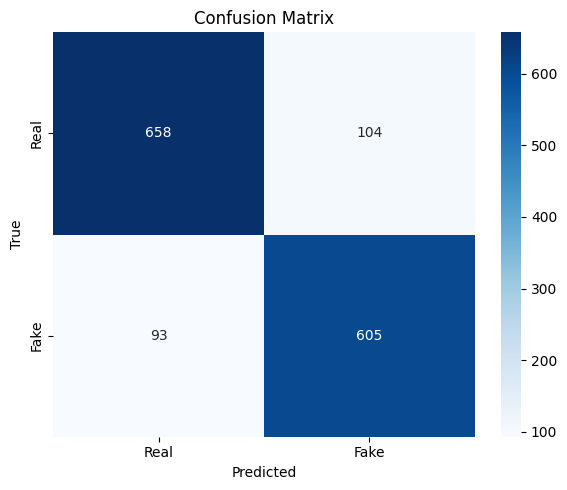

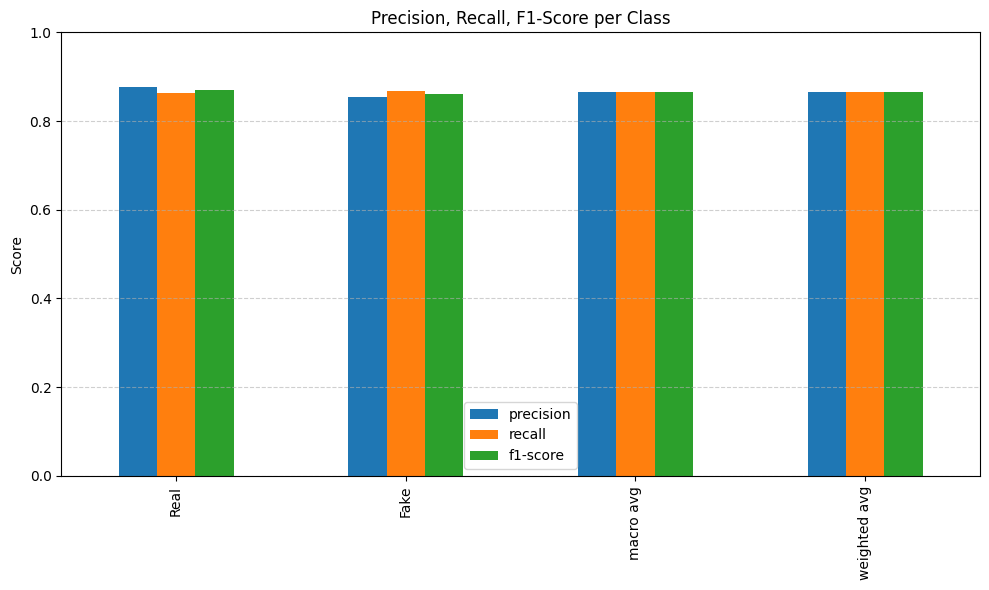

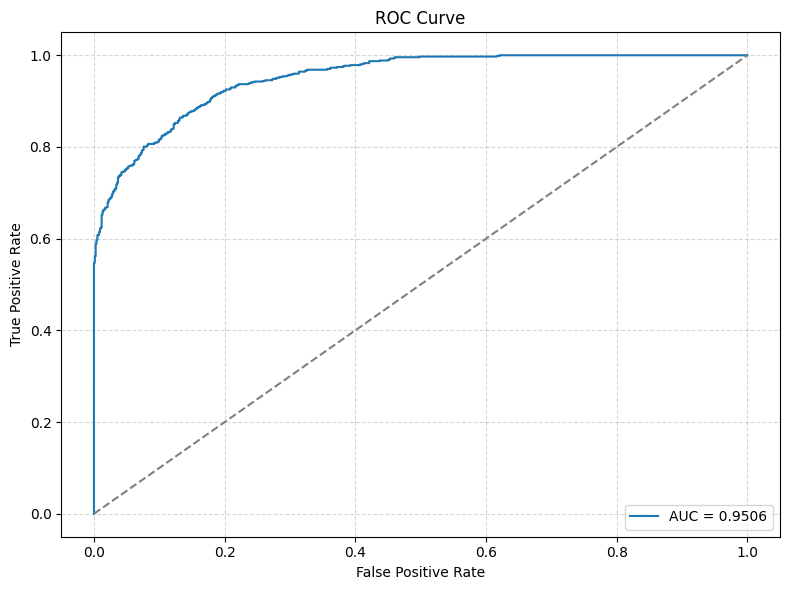

In [124]:
acc, auc, cm, y_true, y_pred, y_probs = evaluate(model, test_loader, device=device)
print(f"\nTest Accuracy: {acc:.4f}")
labels=['Real', 'Fake']
plot_confusion_matrix(cm, labels)
plot_classification_report(y_true, y_pred, labels)
plot_roc_curve(y_true, y_probs)